---
syncID: 5be9f80592394af3bc09cf8e469fef6e
title: "Using neonUtilities in Python"
description: "Use the neonUtilities R package in Python, via the rpy2 library."
dateCreated: 2018-5-10
authors: Claire K. Lunch
contributors: Donal O'Leary
estimatedTime: 0.5 hour
packagesLibraries: rpy2
topics: data-management,rep-sci
languagesTool: python
dataProduct: 
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/NEON-general/neon-code-packages/neonUtilitiesPython/neonUtilitiesPython.py
tutorialSeries: 
urlTitle: neon-utilities-python
---

The instructions below will guide you through using the neonUtilities R package 
in Python, via the rpy2 package. rpy2 creates an R environment you can interact 
with from Python.

The assumption in this tutorial is that you want to work with NEON data in 
Python, but you want to use the handy download and merge functions provided by 
the `neonUtilities` R package to access and format the data for analysis. If 
you want to do your analyses in R, use one of the R-based tutorials linked 
below.

For more information about the `neonUtilities` package, and instructions for 
running it in R directly, see the <a href="https://www.neonscience.org/download-explore-neon-data" target="_blank">Download and Explore</a> tutorial 
and/or the <a href="http://www.neonscience.org/neonDataStackR" target="_blank">neonUtilities tutorial</a>.


## Install and set up

Before starting, you will need:

1. Python 3 installed. It is probably possible to use this workflow in Python 2, 
but these instructions were developed and tested using 3.7.4.
2. R installed. You don't need to have ever used it directly. We wrote this 
tutorial using R 4.1.1, but most other recent versions should also work.
3. `rpy2` installed. Run the line below from the command line, it won't run within 
Jupyter. See <a href="https://docs.python.org/3/installing/" target="_blank">Python documentation</a> for more information on how to install packages. 
`rpy2` often has install problems on Windows, see "Windows Users" section below if 
you are running Windows.
4. You may need to install `pip` before installing `rpy2`, if you don't have it 
installed already.

From the command line, run:

In [1]:
pip install rpy2

Note: you may need to restart the kernel to use updated packages.


### Windows users

The rpy2 package was built for Mac, and doesn't always work smoothly on Windows. 
If you have trouble with the install, try these steps.

1. Add C:\Program Files\R\R-3.3.1\bin\x64 to the Windows Environment Variable “Path”
2. Install rpy2 manually from https://www.lfd.uci.edu/~gohlke/pythonlibs/#rpy2
    1. Pick the correct version. At the download page the portion of the files 
    with cp## relate to the Python version. e.g., rpy2 2.9.2 cp36 cp36m win_amd64.whl 
    is the correct download when 2.9.2 is the latest version of rpy2 and you are 
    running Python 36 and 64 bit Windows (amd64).
    2. Save the whl file, navigate to it in windows then run pip directly on the file 
    as follows “pip install rpy2 2.9.2 cp36 cp36m win_amd64.whl”
3. Add  an R_HOME Windows environment variable with the path C:\Program Files\R\R-3.4.3 
(or whichever version you are running)
4. Add an R_USER Windows environment variable with the path C:\Users\yourUserName\AppData\Local\Continuum\Anaconda3\Lib\site-packages\rpy2

### Additional troubleshooting

If you're still having trouble getting R to communicate with Python, you can try 
pointing Python directly to your R installation path.

1. Run `R.home()` in R.
2. Run `import os` in Python.
3. Run `os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'` in Python, substituting the file path you found in step 1.

## Load packages

Now import `rpy2` into your session.

In [2]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

Load the base R functionality, using the `rpy2` function `importr()`.

In [3]:
base = importr('base')
utils = importr('utils')
stats = importr('stats')

The basic syntax for running R code via `rpy2` is `package.function(inputs)`, 
where `package` is the R package in use, `function` is the name of the function 
within the R package, and `inputs` are the inputs to the function. In other 
words, it's very similar to running code in R as `package::function(inputs)`. 
For example:

In [4]:
stats.rnorm(6, 0, 1)

-0.938409,0.189041,-0.169062,0.976939,-0.862790,0.648383


Suppress R warnings. This step can be skipped, but will result in messages 
getting passed through from R that Python will interpret as warnings.

In [5]:
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

Install the `neonUtilities` R package. Here I've specified the RStudio 
CRAN mirror as the source, but you can use a different one if you 
prefer.

You only need to do this step once to use the package, but we update 
the `neonUtilities` package every few months, so reinstalling 
periodically is recommended.

This installation step carries out the same steps in the same places on 
your hard drive that it would if run in R directly, so if you use R 
regularly and have already installed `neonUtilities` on your machine, 
you can skip this step. And be aware, this also means if you install 
other packages, or new versions of packages, via `rpy2`, they'll 
be updated the next time you use R, too.

The semicolon at the end of the line (here, and in some other function 
calls below) can be omitted. It suppresses a note indicating the output 
of the function is null. The output is null because these functions download 
or modify files on your local drive, but none of the data are read into the 
Python or R environments.

In [6]:
utils.install_packages('neonUtilities', repos='https://cran.rstudio.com/');


The downloaded binary packages are in
	/var/folders/_k/gbjn452j1h3fk7880d5ppkx1_9xf6m/T//Rtmpdy9fY1/downloaded_packages


Now load the `neonUtilities` package. This does need to be run every time 
you use the code; if you're familiar with R, `importr()` is roughly 
equivalent to the `library()` function in R.

In [7]:
neonUtilities = importr('neonUtilities')

## Join data files: stackByTable()

The function `stackByTable()` in `neonUtilities` merges the monthly, 
site-level files the <a href="http://data.neonscience.org/home" target="_blank">NEON Data Portal</a> 
provides. Start by downloading the dataset you're interested in from the 
Portal. Here, we'll assume you've downloaded IR Biological Temperature. 
It will download as a single zip file named `NEON_temp-bio.zip`. Note the 
file path it's saved to and proceed.

Run the `stackByTable()` function to stack the data. It requires only one 
input, the path to the zip file you downloaded from the NEON Data Portal. 
Modify the file path in the code below to match the path on your machine.

For additional, optional inputs to `stackByTable()`, see the <a href="http://neonscience.org/neonDataStackR" target="_blank">R tutorial</a> 
for neonUtilities.

In [8]:
neonUtilities.stackByTable(filepath='/Users/Shared/NEON_temp-bio.zip');

Stacking operation across a single core.
Stacking table IRBT_1_minute
Stacking table IRBT_30_minute
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 2 data tables and 3 metadata tables!
Stacking took 1.585054 secs
All unzipped monthly data folders have been removed.


Check the folder containing the original zip file from the Data Portal; 
you should now have a subfolder containing the unzipped and stacked files 
called `stackedFiles`. To import these data to Python, skip ahead to the 
"Read downloaded and stacked files into Python" section; to learn how to 
use `neonUtilities` to download data, proceed to the next section.

## Download files to be stacked: zipsByProduct()

The function `zipsByProduct()` uses the <a href="http://data.neonscience.org/data-api" target="_blank">NEON API</a> to programmatically download 
data files for a given product. The files downloaded by `zipsByProduct()` 
can then be fed into `stackByTable()`.

Run the downloader with these inputs: a data product ID (DPID), a set of 
4-letter site IDs (or "all" for all sites), a download package (either 
basic or expanded), the filepath to download the data to, and an 
indicator to check the size of your download before proceeding or not 
(TRUE/FALSE).

The DPID is the data product identifier, and can be found in the data product 
box on the NEON <a href="https://data.neonscience.org/data-products/explore" target="_blank">Explore Data</a> page. 
Here we'll download Breeding landbird point counts, DP1.10003.001.

There are two differences relative to running `zipsByProduct()` in R directly: 

1. `check.size` becomes `check_size`, because dots have programmatic meaning 
in Python
2. `TRUE` (or `T`) becomes `'TRUE'` because the values TRUE and FALSE don't 
have special meaning in Python the way they do in R, so it interprets them 
as variables if they're unquoted.

`check_size='TRUE'` does not work correctly in the Python environment. It 
estimates the size of the download and asks you to confirm before proceeding, 
and this interactive display doesn't work correctly outside R. Set 
`check_size='FALSE'` to avoid this problem, but be thoughtful about the size 
of your query since it will proceed to download without checking.

In [9]:
neonUtilities.zipsByProduct(dpID='DP1.10003.001', 
                            site=base.c('HARV','BART'), 
                            savepath='/Users/Shared',
                            package='basic', 
                            check_size='FALSE');

Finding available files
  |======================================================================| 100%

  |======================================================================| 100%
16 files successfully downloaded to /Users/Shared/filesToStack10003


The message output by `zipsByProduct()` indicates the file path where the 
files have been downloaded.

Now take that file path and pass it to `stackByTable()`.

In [10]:
neonUtilities.stackByTable(filepath='/Users/Shared/filesToStack10003');

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table brd_countdata
Stacking table brd_perpoint
Copied the most recent publication of validation file to /stackedFiles
Copied the most recent publication of categoricalCodes file to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 2 data tables and 4 metadata tables!
Stacking took 0.3076231 secs
All unzipped monthly data folders have been removed.


## Read downloaded and stacked files into Python

We've downloaded biological temperature and bird data, and merged 
the site by month files. Now let's read those data into Python so you 
can proceed with analyses.

First let's take a look at what's in the output folders.

In [11]:
import os
os.listdir('/Users/Shared/filesToStack10003/stackedFiles/')

['categoricalCodes_10003.csv',
 'issueLog_10003.csv',
 'brd_countdata.csv',
 'brd_perpoint.csv',
 'readme_10003.txt',
 'variables_10003.csv',
 'validation_10003.csv']

In [12]:
os.listdir('/Users/Shared/NEON_temp-bio/stackedFiles/')

['IRBT_1_minute.csv',
 'sensor_positions_00005.csv',
 'issueLog_00005.csv',
 'IRBT_30_minute.csv',
 'variables_00005.csv',
 'readme_00005.txt']

Each data product folder contains a set of data files and metadata files. 
Here, we'll read in the data files and take a look at the contents; for 
more details about the contents of NEON data files and how to interpret them, 
see the <a href="https://www.neonscience.org/download-explore-neon-data" target="_blank">Download and Explore tutorial</a>.

There are a variety of modules and methods for reading tabular data into 
Python; here we'll use the `pandas` module, but feel free to use your own 
preferred method.

First, let's read in the two data tables in the bird data: 
`brd_countdata` and `brd_perpoint`.

In [13]:
import pandas
brd_perpoint = pandas.read_csv('/Users/Shared/filesToStack10003/stackedFiles/brd_perpoint.csv')
brd_countdata = pandas.read_csv('/Users/Shared/filesToStack10003/stackedFiles/brd_countdata.csv')

And take a look at the contents of each file. For descriptions and unit of each 
column, see the `variables_10003` file.

In [14]:
brd_perpoint

,uid,namedLocation,domainID,siteID,plotID,plotType,pointID,nlcdClass,decimalLatitude,decimalLongitude,...,endRH,observedHabitat,observedAirTemp,kmPerHourObservedWindSpeed,laboratoryName,samplingProtocolVersion,remarks,measuredBy,publicationDate,release
0,32ab1419-b087-47e1-829d-b1a67a223a01,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,evergreenForest,44.060146,-71.315479,...,56.0,evergreen forest,18.0,1.0,Bird Conservancy of the Rockies,NEON.DOC.014041vG,NaN,JRUEB,20211222T013942Z,RELEASE-2022
1,f02e2458-caab-44d8-a21a-b3b210b71006,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,B1,evergreenForest,44.060146,-71.315479,...,56.0,deciduous forest,19.0,3.0,Bird Conservancy of the Rockies,NEON.DOC.014041vG,NaN,JRUEB,20211222T013942Z,RELEASE-2022
2,58ccefb8-7904-4aa6-8447-d6f6590ccdae,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,A1,evergreenForest,44.060146,-71.315479,...,56.0,mixed deciduous/evergreen forest,17.0,0.0,Bird Conservancy of the Rockies,NEON.DOC.014041vG,NaN,JRUEB,20211222T013942Z,RELEASE-2022
3,1b14ead4-03fc-4d47-bd00-2f6e31cfe971,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,A2,evergreenForest,44.060146,-71.315479,...,56.0,deciduous forest,19.0,0.0,Bird Conservancy of the Rockies,NEON.DOC.014041vG,NaN,JRUEB,20211222T013942Z,RELEASE-2022
4,3055a0a5-57ae-4e56-9415-eeb7704fab02,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,B2,evergreenForest,44.060146,-71.315479,...,56.0,deciduous forest,16.0,0.0,Bird Conservancy of the Rockies,NEON.DOC.014041vG,NaN,JRUEB,20211222T013942Z,RELEASE-2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,3400dfdf-54f1-4921-a3b0-61f03c6db3e9,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A1,deciduousForest,42.401149,-72.253238,...,43.0,other,16.0,10.0,Bird Conservancy of the Rockies,NEON.DOC.014041vK,"The RH would not stay still today, kept swingi...",JGLAG,20211222T011332Z,PROVISIONAL
1235,b43b199c-51b6-4222-b575-7564315e47bb,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A2,deciduousForest,42.401149,-72.253238,...,43.0,deciduous forest,15.0,4.0,Bird Conservancy of the Rockies,NEON.DOC.014041vK,"The RH would not stay still today, kept swingi...",JGLAG,20211222T011332Z,PROVISIONAL
1236,a7040ad5-d253-47b7-964d-2711dafa42c4,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,B2,deciduousForest,42.401149,-72.253238,...,43.0,deciduous forest,16.0,1.0,Bird Conservancy of the Rockies,NEON.DOC.014041vK,"The RH would not stay still today, kept swingi...",JGLAG,20211222T011332Z,PROVISIONAL
1237,97a3c2dc-d8b0-436f-af62-00c88167b60e,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,B3,deciduousForest,42.401149,-72.253238,...,43.0,deciduous forest,17.0,1.0,Bird Conservancy of the Rockies,NEON.DOC.014041vK,"The RH would not stay still today, kept swingi...",JGLAG,20211222T011332Z,PROVISIONAL


In [15]:
brd_countdata

,uid,namedLocation,domainID,siteID,plotID,plotType,pointID,startDate,eventID,pointCountMinute,...,vernacularName,observerDistance,detectionMethod,visualConfirmation,sexOrAge,clusterSize,clusterCode,identifiedBy,publicationDate,release
0,4e22256f-5e86-4a2c-99be-dd1c7da7af28,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,2015-06-14T09:23Z,BART_025.C1.2015-06-14,1,...,Black-capped Chickadee,42.0,singing,No,Male,1.0,NaN,JRUEB,20211222T013942Z,RELEASE-2022
1,93106c0d-06d8-4816-9892-15c99de03c91,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,2015-06-14T09:23Z,BART_025.C1.2015-06-14,1,...,Red-eyed Vireo,9.0,singing,No,Male,1.0,NaN,JRUEB,20211222T013942Z,RELEASE-2022
2,5eb23904-9ae9-45bf-af27-a4fa1efd4e8a,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,2015-06-14T09:23Z,BART_025.C1.2015-06-14,2,...,Black-and-white Warbler,17.0,singing,No,Male,1.0,NaN,JRUEB,20211222T013942Z,RELEASE-2022
3,99592c6c-4cf7-4de8-9502-b321e925684d,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,2015-06-14T09:23Z,BART_025.C1.2015-06-14,2,...,Black-throated Green Warbler,50.0,singing,No,Male,1.0,NaN,JRUEB,20211222T013942Z,RELEASE-2022
4,6c07d9fb-8813-452b-8182-3bc5e139d920,BART_025.birdGrid.brd,D01,BART,BART_025,distributed,C1,2015-06-14T09:23Z,BART_025.C1.2015-06-14,1,...,Black-throated Green Warbler,12.0,singing,No,Male,1.0,NaN,JRUEB,20211222T013942Z,RELEASE-2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,87c9dae4-ee30-4673-b669-5ca8acdc7bd7,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A3,2021-06-16T13:08Z,HARV_006.A3.2021-06-16,1,...,Eastern Towhee,13.0,calling,No,Unknown,1.0,NaN,JGLAG,20211222T011332Z,PROVISIONAL
13580,1a65553a-6189-4c74-a1e3-2ada0f1d9f63,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A3,2021-06-16T13:08Z,HARV_006.A3.2021-06-16,4,...,NaN,20.0,visual,No,Unknown,1.0,NaN,JGLAG,20211222T011332Z,PROVISIONAL
13581,e33deb1c-e79d-41dc-8fc1-8e984b9d0450,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A3,2021-06-16T13:08Z,HARV_006.A3.2021-06-16,1,...,Eastern Towhee,48.0,calling,No,Unknown,1.0,NaN,JGLAG,20211222T011332Z,PROVISIONAL
13582,070ec577-9aec-4d05-91df-86124d383697,HARV_006.birdGrid.brd,D01,HARV,HARV_006,distributed,A3,2021-06-16T13:08Z,HARV_006.A3.2021-06-16,1,...,Eastern Towhee,61.0,singing,No,Unknown,1.0,NaN,JGLAG,20211222T011332Z,PROVISIONAL


And now let's do the same with the 30-minute data table for biological 
temperature.

In [16]:
IRBT30 = pandas.read_csv('/Users/Shared/NEON_temp-bio/stackedFiles/IRBT_30_minute.csv')
IRBT30

,domainID,siteID,horizontalPosition,verticalPosition,startDateTime,endDateTime,bioTempMean,bioTempMinimum,bioTempMaximum,bioTempVariance,bioTempNumPts,bioTempExpUncert,bioTempStdErMean,finalQF,publicationDate,release
0,D18,BARR,0,10,2021-09-01T00:00:00Z,2021-09-01T00:30:00Z,7.82,7.43,8.39,0.03,1800.0,0.60,0.00,0,20211219T025212Z,PROVISIONAL
1,D18,BARR,0,10,2021-09-01T00:30:00Z,2021-09-01T01:00:00Z,7.47,7.16,7.75,0.01,1800.0,0.60,0.00,0,20211219T025212Z,PROVISIONAL
2,D18,BARR,0,10,2021-09-01T01:00:00Z,2021-09-01T01:30:00Z,7.43,6.89,8.11,0.07,1800.0,0.60,0.01,0,20211219T025212Z,PROVISIONAL
3,D18,BARR,0,10,2021-09-01T01:30:00Z,2021-09-01T02:00:00Z,7.36,6.78,8.15,0.06,1800.0,0.60,0.01,0,20211219T025212Z,PROVISIONAL
4,D18,BARR,0,10,2021-09-01T02:00:00Z,2021-09-01T02:30:00Z,6.91,6.50,7.27,0.03,1800.0,0.60,0.00,0,20211219T025212Z,PROVISIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,D18,BARR,3,0,2021-11-30T21:30:00Z,2021-11-30T22:00:00Z,-14.62,-14.78,-14.46,0.00,1800.0,0.57,0.00,0,20211206T221914Z,PROVISIONAL
13100,D18,BARR,3,0,2021-11-30T22:00:00Z,2021-11-30T22:30:00Z,-14.59,-14.72,-14.50,0.00,1800.0,0.57,0.00,0,20211206T221914Z,PROVISIONAL
13101,D18,BARR,3,0,2021-11-30T22:30:00Z,2021-11-30T23:00:00Z,-14.56,-14.65,-14.45,0.00,1800.0,0.57,0.00,0,20211206T221914Z,PROVISIONAL
13102,D18,BARR,3,0,2021-11-30T23:00:00Z,2021-11-30T23:30:00Z,-14.50,-14.60,-14.39,0.00,1800.0,0.57,0.00,0,20211206T221914Z,PROVISIONAL


## Download remote sensing files: byFileAOP()

The function `byFileAOP()` uses the <a href="http://data.neonscience.org/data-api" target="_blank">NEON API</a> 
to programmatically download data files for remote sensing (AOP) data 
products. These files cannot be stacked by `stackByTable()` because they 
are not tabular data. The function simply creates a folder in your working 
directory and writes the files there. It preserves the folder structure 
for the subproducts.

The inputs to `byFileAOP()` are a data product ID, a site, a year, 
a filepath to save to, and an indicator to check the size of the 
download before proceeding, or not. As above, set check_size="FALSE" 
when working in Python. Be especially cautious about download size 
when downloading AOP data, since the files are very large.

Here, we'll download Ecosystem structure (Canopy Height Model) data from 
Hopbrook (HOPB) in 2017.

In [17]:
neonUtilities.byFileAOP(dpID='DP3.30015.001', site='HOPB',
                        year='2017', check_size='FALSE',
                       savepath='/Users/Shared');

  |======================================================================| 100%
Successfully downloaded  217  files.
NEON_D01_HOPB_DP1_716000_4706000_classified_point_cloud.dbf downloaded to /Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/Metadata/DiscreteLidar/TileBoundary/shps
NEON_D01_HOPB_DP1_716000_4709000_classified_point_cloud.dbf downloaded to /Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/Metadata/DiscreteLidar/TileBoundary/shps
NEON_D01_HOPB_DP3_720000_4710000_CHM.tif downloaded to /Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/L3/DiscreteLidar/CanopyHeightModelGtif
NEON_D01_HOPB_DP1_720000_4709000_classified_point_cloud.prj downloaded to /Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/Metadata/DiscreteLidar/TileBoundary/shps
NEON_D01_HOPB_DP3_717000_4705000_CHM.tif downloaded to /Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/L3/Discre

Let's read one tile of data into Python and view it. We'll use the 
`rasterio` and `matplotlib` modules here, but as with tabular data, 
there are other options available.

In [18]:
import rasterio
CHMtile = rasterio.open('/Users/Shared/DP3.30015.001/neon-aop-products/2017/FullSite/D01/2017_HOPB_2/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D01_HOPB_DP3_718000_4709000_CHM.tif')

In [19]:
import matplotlib.pyplot as plt
from rasterio.plot import show
fig, ax = plt.subplots(figsize = (8,3))
show(CHMtile)

<Figure size 800x300 with 1 Axes>

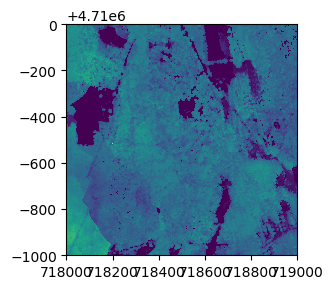

In [20]:
fig